# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [137]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [114]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [115]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [116]:
resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

100%|██████████| 111M/111M [00:02<00:00, 46.4MB/s] 


#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [138]:
dataset = datasets.ImageFolder('../images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=training.collate_pil, num_workers=workers)

In [139]:
dataset.idx_to_class

{0: 'JackHarlow',
 1: 'KanyeWest',
 2: 'MargotRobbie',
 3: 'PrinceHarry',
 4: 'TomHolland',
 5: 'angelina_jolie',
 6: 'bradley_cooper',
 7: 'kate_siegel',
 8: 'paul_rudd',
 9: 'shea_whigham'}

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [140]:
aligned = []
names = []
# only get one image per person
# people = set()
for x, y in loader:
    person = dataset.idx_to_class[y]
    # if person in people:
    #     continue
    # people.add(person)
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        #print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(person)
    else:
        # print path of images that are not detected
        print(f"person not detection {person}")

TypeError: unhashable type: 'list'

In [141]:
%debug


> c:\users\anshu\appdata\local\temp\ipykernel_24388\732504421.py(6)<module>()

[0]
      1 aligned = []
      2 names = []
      3 # only get one image per person
      4 # people = set()
      5 for x, y in loader:
----> 6     person = dataset.idx_to_class[y]
      7     # if person in people:
      8     #     continue
      9     # people.add(person)
     10     x_aligned, prob = mtcnn(x, return_prob=True)
     11     if x_aligned is not None:

[0]


In [121]:
# split up aligned images into batches
aligned = torch.stack(aligned)
aligned = torch.split(aligned, 32)
# pass each batch through resnet
embeddings = []
for batch in aligned:
    embeddings.extend(resnet(batch.to(device)).detach().cpu())

In [122]:
# convert embeddings to numpy
embeddings = torch.stack(embeddings).numpy()
names = np.array(names)
# save embeddings and names
np.save('embeddings.npy', embeddings)
np.save('names.npy', names)

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [123]:
import numpy as np
from sklearn.metrics import roc_curve, auc

class FacialVerifier:
    def __init__(self, known_embeddings):
        self.known_embeddings = known_embeddings
    
    def verify(self, unknown_embeddings, true_labels, name, thresholds):
        distances = self._compute_distances(unknown_embeddings)
        
        # all true labels with name should be 1, all others should be 0
        true_labels = np.array([1 if label == name else 0 for label in true_labels])
     
        fpr_list = []
        tpr_list = []
        
        for threshold in thresholds:
            predicted_labels = np.array(distances) <= threshold
            
            tp = np.sum((predicted_labels == 1) & (true_labels == 1))
            fp = np.sum((predicted_labels == 1) & (true_labels == 0))
            tn = np.sum((predicted_labels == 0) & (true_labels == 0))
            fn = np.sum((predicted_labels == 0) & (true_labels == 1))
            
            fpr = fp / (fp + tn)
            tpr = tp / (tp + fn)
            
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            
            accuracy = (tp + tn) / len(unknown_embeddings)
            print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")
        return fpr_list, tpr_list
    
    def _compute_distances(self, unknown_embeddings):
        distances = []
        for embedding in unknown_embeddings:
            min_distance = float('inf')
            for known_embedding in self.known_embeddings:
                distance = np.linalg.norm(embedding - known_embedding)
                min_distance = min(min_distance, distance)
            distances.append(min_distance)
        return distances
    
    def _compute_accuracy(self, distances, true_labels, threshold):
        predicted_labels = np.array(distances) <= threshold
        accuracy = np.mean(predicted_labels == true_labels)
        return accuracy
    
    def compute_auc(self, fpr_list, tpr_list):
        auc = np.trapz(tpr_list, fpr_list)
        return auc


Threshold: 0.00, Accuracy: 0.84, FPR: 0.00, TPR: 0.05
Threshold: 0.10, Accuracy: 0.84, FPR: 0.00, TPR: 0.05
Threshold: 0.20, Accuracy: 0.84, FPR: 0.00, TPR: 0.05
Threshold: 0.30, Accuracy: 0.84, FPR: 0.00, TPR: 0.05
Threshold: 0.40, Accuracy: 0.84, FPR: 0.00, TPR: 0.05
Threshold: 0.50, Accuracy: 0.85, FPR: 0.00, TPR: 0.10
Threshold: 0.60, Accuracy: 0.85, FPR: 0.00, TPR: 0.10
Threshold: 0.70, Accuracy: 0.85, FPR: 0.00, TPR: 0.14
Threshold: 0.80, Accuracy: 0.90, FPR: 0.00, TPR: 0.43
Threshold: 0.90, Accuracy: 0.98, FPR: 0.00, TPR: 0.86
Threshold: 1.00, Accuracy: 1.00, FPR: 0.00, TPR: 1.00
Threshold: 1.10, Accuracy: 1.00, FPR: 0.00, TPR: 1.00
Threshold: 1.20, Accuracy: 1.00, FPR: 0.00, TPR: 1.00
Threshold: 1.30, Accuracy: 0.98, FPR: 0.02, TPR: 1.00
Threshold: 1.40, Accuracy: 0.78, FPR: 0.26, TPR: 1.00
Threshold: 1.50, Accuracy: 0.29, FPR: 0.85, TPR: 1.00
Threshold: 1.60, Accuracy: 0.17, FPR: 1.00, TPR: 1.00
Threshold: 1.70, Accuracy: 0.17, FPR: 1.00, TPR: 1.00
Threshold: 1.80, Accuracy: 0

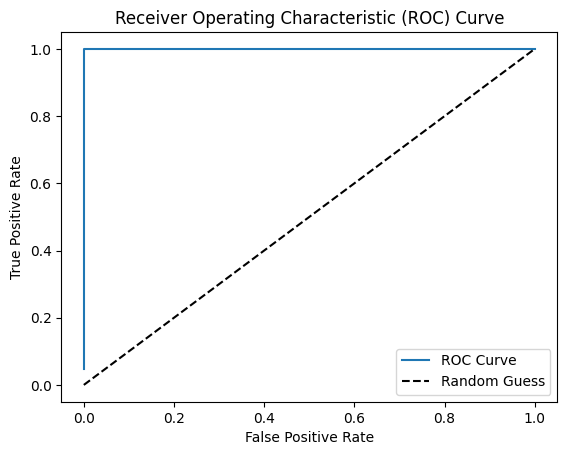

AUC: 1.0000


In [135]:

import matplotlib.pyplot as plt
celeb_name = 'KanyeWest'
celeb_embedding = embeddings[names == celeb_name]
known_embeddings = celeb_embedding[:5]
verifier = FacialVerifier(known_embeddings=known_embeddings)
thresholds = np.arange(0, 2, 0.1)
fpr_list, tpr_list = verifier.verify(embeddings, true_labels=names, name=celeb_name, thresholds=thresholds)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_list, tpr_list, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Compute the AUC
auc = verifier.compute_auc(fpr_list, tpr_list)
print(f"AUC: {auc:.4f}")

